In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

In [2]:
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>1]=1
protec=read_img(drv_path+'WDPA_WDOECM_poly_Nov2023_AF_001_afr.tif')[0]
protec[protec>1]=1
ele_protect=ele*protec
data=ele+ele_protect

In [17]:
np.nanmin(data),np.nanmax(data)

(1.0, 2.0)

In [36]:
data.shape

(6500, 7900)

<Figure size 600x800 with 0 Axes>

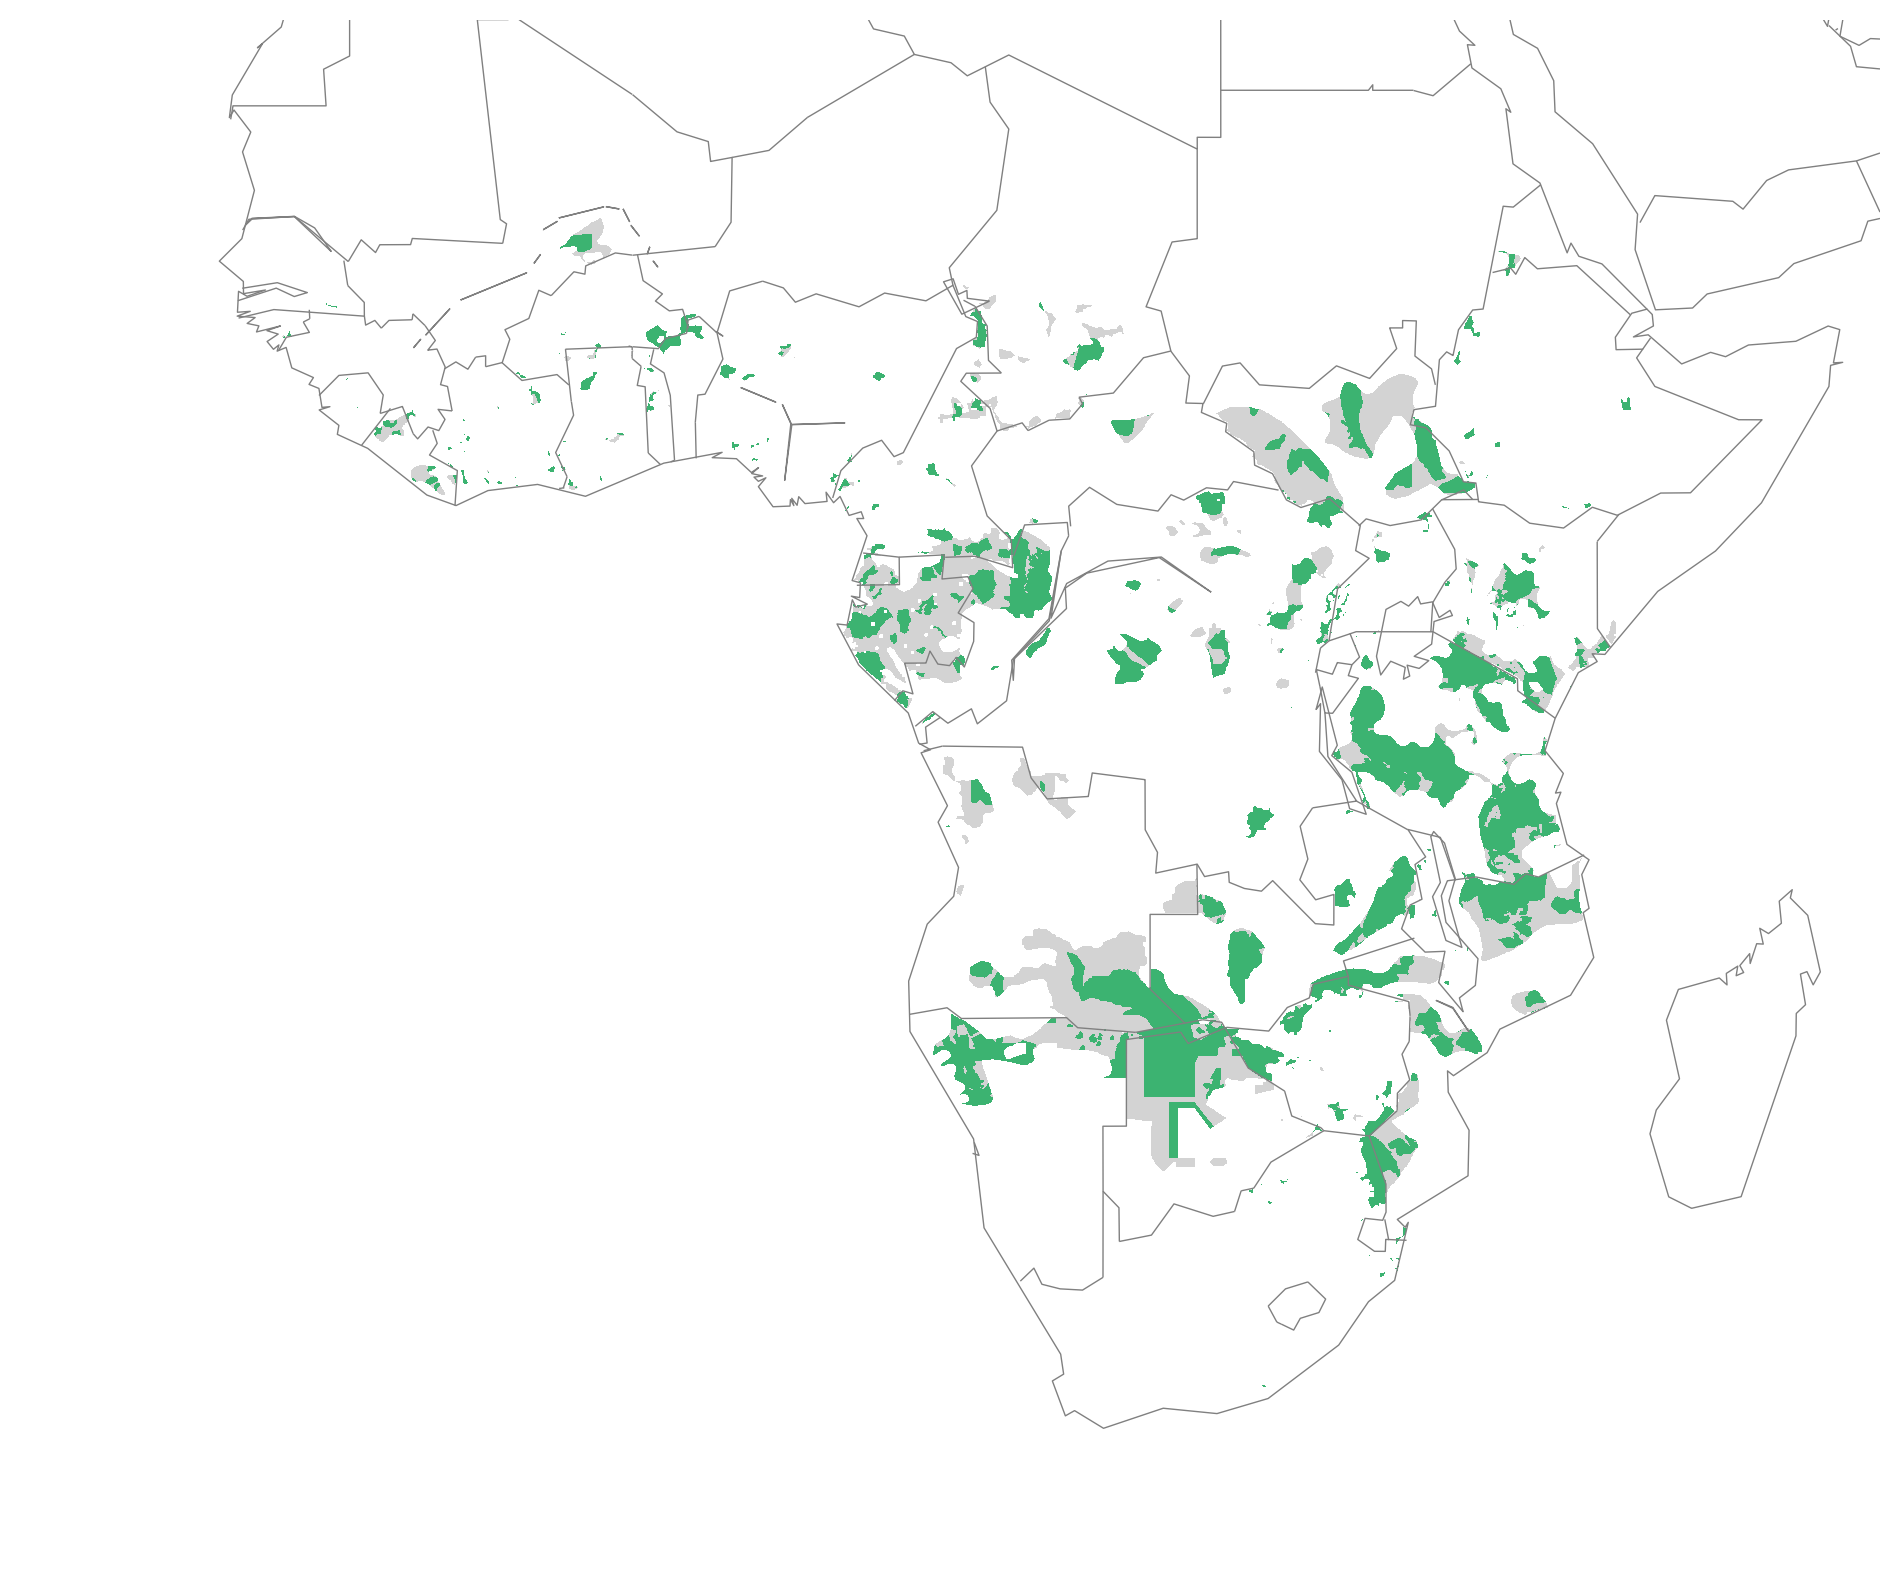

In [63]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
fig=plt.figure(figsize=(6,8))

#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26;lon2 = 53
lat1 = -40;lat2 = 25
fig = plt.figure(figsize=(12,10)) ##width, height default(8,6)
ax = fig.add_subplot(1,1,1)
m = Basemap(width=7900,height=6500,llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
#m.drawmapboundary(linewidth = 0.5)
m.drawcountries(linewidth = 0.5, color = 'gray')
#m.fillcontinents(color = (240/256, 240/256, 240/256))
m.drawlsmask(land_color='none',ocean_color='none',lakes=False)#'gainsboro'#(135/256, 206/256, 234/256)
m.drawcoastlines(linewidth=0.5, color='gray')
data=data.astype(np.float32)
data[data == 0] = np.nan
#ele=ele.astype(np.float32)
#ele[ele == 0] = np.nan
#ele_protect=ele_protect.astype(np.float32)
#ele_protect[ele_protect == 0] = np.nan
#cmap_custom = matplotlib.cm.ocean_r
#cmap_custom.set_under('white')#指定最小值的颜色
colors=['none','lightgray','mediumseagreen']
cmap = mpl.colors.ListedColormap(colors)
im =m.imshow(data,cmap =cmap,origin='upper',vmin=0)#
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#position=fig.add_axes([0.15, 0.25, 0.25, 0.02])#位置[左,下,右,宽]
#cb = plt.colorbar(im,cax=position,orientation='horizontal')
#cb.ax.tick_params(labelsize=15) 
#cb.set_label('Elephant population density (n/$100km^2$)',fontsize=18,labelpad=10,loc='left')

# Calculate areas

In [12]:
reso=0.01 #数据分辨率
nlon = int(360 / reso)#列数
nlat = int(180 / reso)#行数
lat_area = np.zeros(nlat) #空矩阵准备存储-90，90维度方向面积
RE = 6371.393  #earth redius 6371.393 k
for i in np.arange(nlat):
    lat_area[i] = abs(2 * np.pi * (RE**2) *
        (np.cos(np.pi * (i + 1) / nlat) - np.cos(np.pi * i / nlat))) / nlon

In [13]:
#(-26.0, 25.0, 53.0, -40.0)
lat_area_afr=lat_area[int((90 - 25) *(1 / reso)):int((90 +40) * (1 / reso))] #从-90，90维度区间中提取目标区间[25, -40]
area = np.zeros((6500, 7900)) 
#经度方向面积一致，补齐经度方向面积，生成面积矩阵
for i in range(7900):
    area[:,i]=lat_area_afr
area.shape

(6500, 7900)

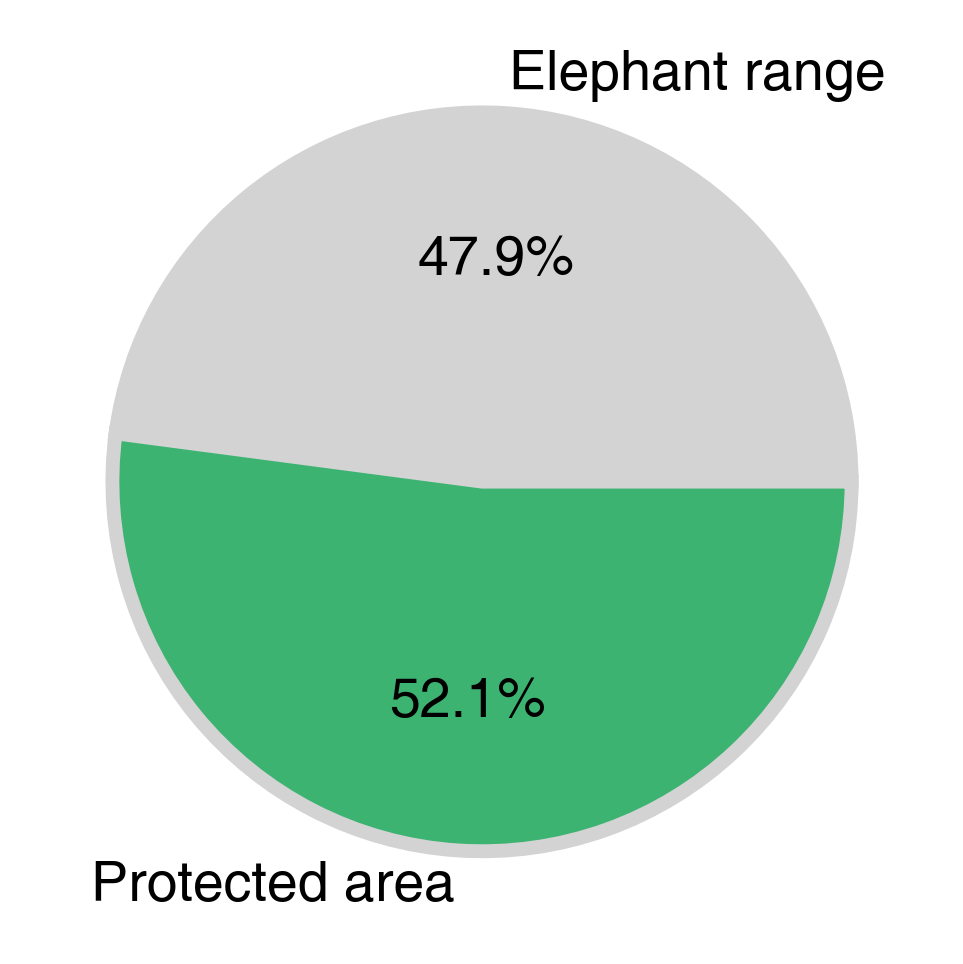

In [65]:
ele_area=np.sum(ele*area)-np.sum(ele_protect*area)#非保护区的大象
protec=np.sum(ele_protect*area)#保护区的大象
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(6,6)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 20}
plt.rc('font', **font)  # pass in the font dict as kwargs
explode=[0,-0.001]#设定各项距离圆心n个半径
cl=['lightgray','mediumseagreen']
#plt.pie(values[-1,3:6],explode=explode,labels=label,autopct='%1.1f%%')#绘制饼图
#crop=crop_area-scat_area-line_area
label=['Elephant range','Protected area']#定义饼图的标签，标签是列表
values=[ele_area,protec]
plt.pie(values,explode=explode,labels=label,colors=cl,autopct='%1.1f%%',pctdistance=0.6,
        wedgeprops={'linewidth': 5, 'edgecolor': "lightgray"},
        textprops= {'fontsize': 20})#绘制饼图
#plt.title('2018年饼图')#绘制标题
#plt.savefig('./2018年饼图')#保存图片
#ax.set(facecolor='none')
fig.patch.set_alpha(0.)
plt.show()

In [66]:
ele_area

1518221.3834439998

In [64]:
protec

1650425.6036627467

# 区分LA-LC

In [78]:
def GetExtent(infile):
    ds = gdal.Open(infile)
    geotrans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    min_x,max_y = geotrans[0],geotrans[3]
    max_x,min_y = geotrans[0]+xsize*geotrans[1],geotrans[3]+ysize*geotrans[5]
    ds = None
    return min_x,max_y,max_x,min_y
tt=GetExtent(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')
print(tt)

(-26.0, 25.0, 53.0, -40.0)


In [80]:
###radiation
gdal.Warp(ele_path+'fireCCI_eleIUCN20_LAextant_mask_001.tif',
          ele_path+'fireCCI_eleIUCN20_LAextant_mask.tif',
          dstSRS='EPSG:4326',
          outputBounds = [tt[0],tt[3],tt[2],tt[1]],
          xRes=0.01,
          yRes=0.01,
          targetAlignedPixels=True,
          resampleAlg = gdalconst.GRA_Average,
          creationOptions = ["COMPRESS=LZW"])
gdal.Warp(ele_path+'fireCCI_eleIUCN20_LCextant_mask_001.tif',
          ele_path+'fireCCI_eleIUCN20_LCextant_mask.tif',
          dstSRS='EPSG:4326',
          outputBounds = [tt[0],tt[3],tt[2],tt[1]],
          xRes=0.01,
          yRes=0.01,
          targetAlignedPixels=True,
          resampleAlg = gdalconst.GRA_Average,
          creationOptions = ["COMPRESS=LZW"])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002BAF5EA09C0> >

In [8]:
LA_da=read_img(ele_path+'fireCCI_eleIUCN20_LAextant_mask_001.tif')[0]
LC_da=read_img(ele_path+'fireCCI_eleIUCN20_LCextant_mask_001.tif')[0]
LA_da=LA_da.astype(np.float32)
LC_da=LC_da.astype(np.float32)
LA_da[LA_da==0]=np.nan
LC_da[LC_da==0]=np.nan

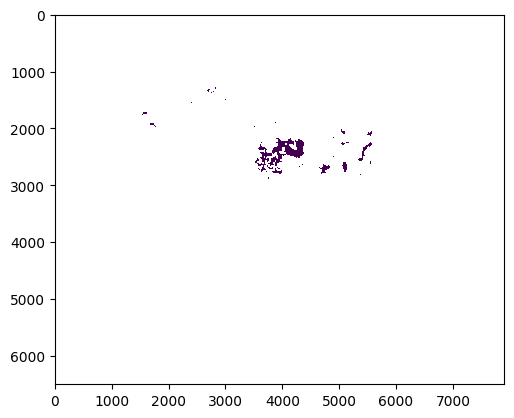

In [9]:
plt.imshow(LC_da)

<Figure size 600x800 with 0 Axes>

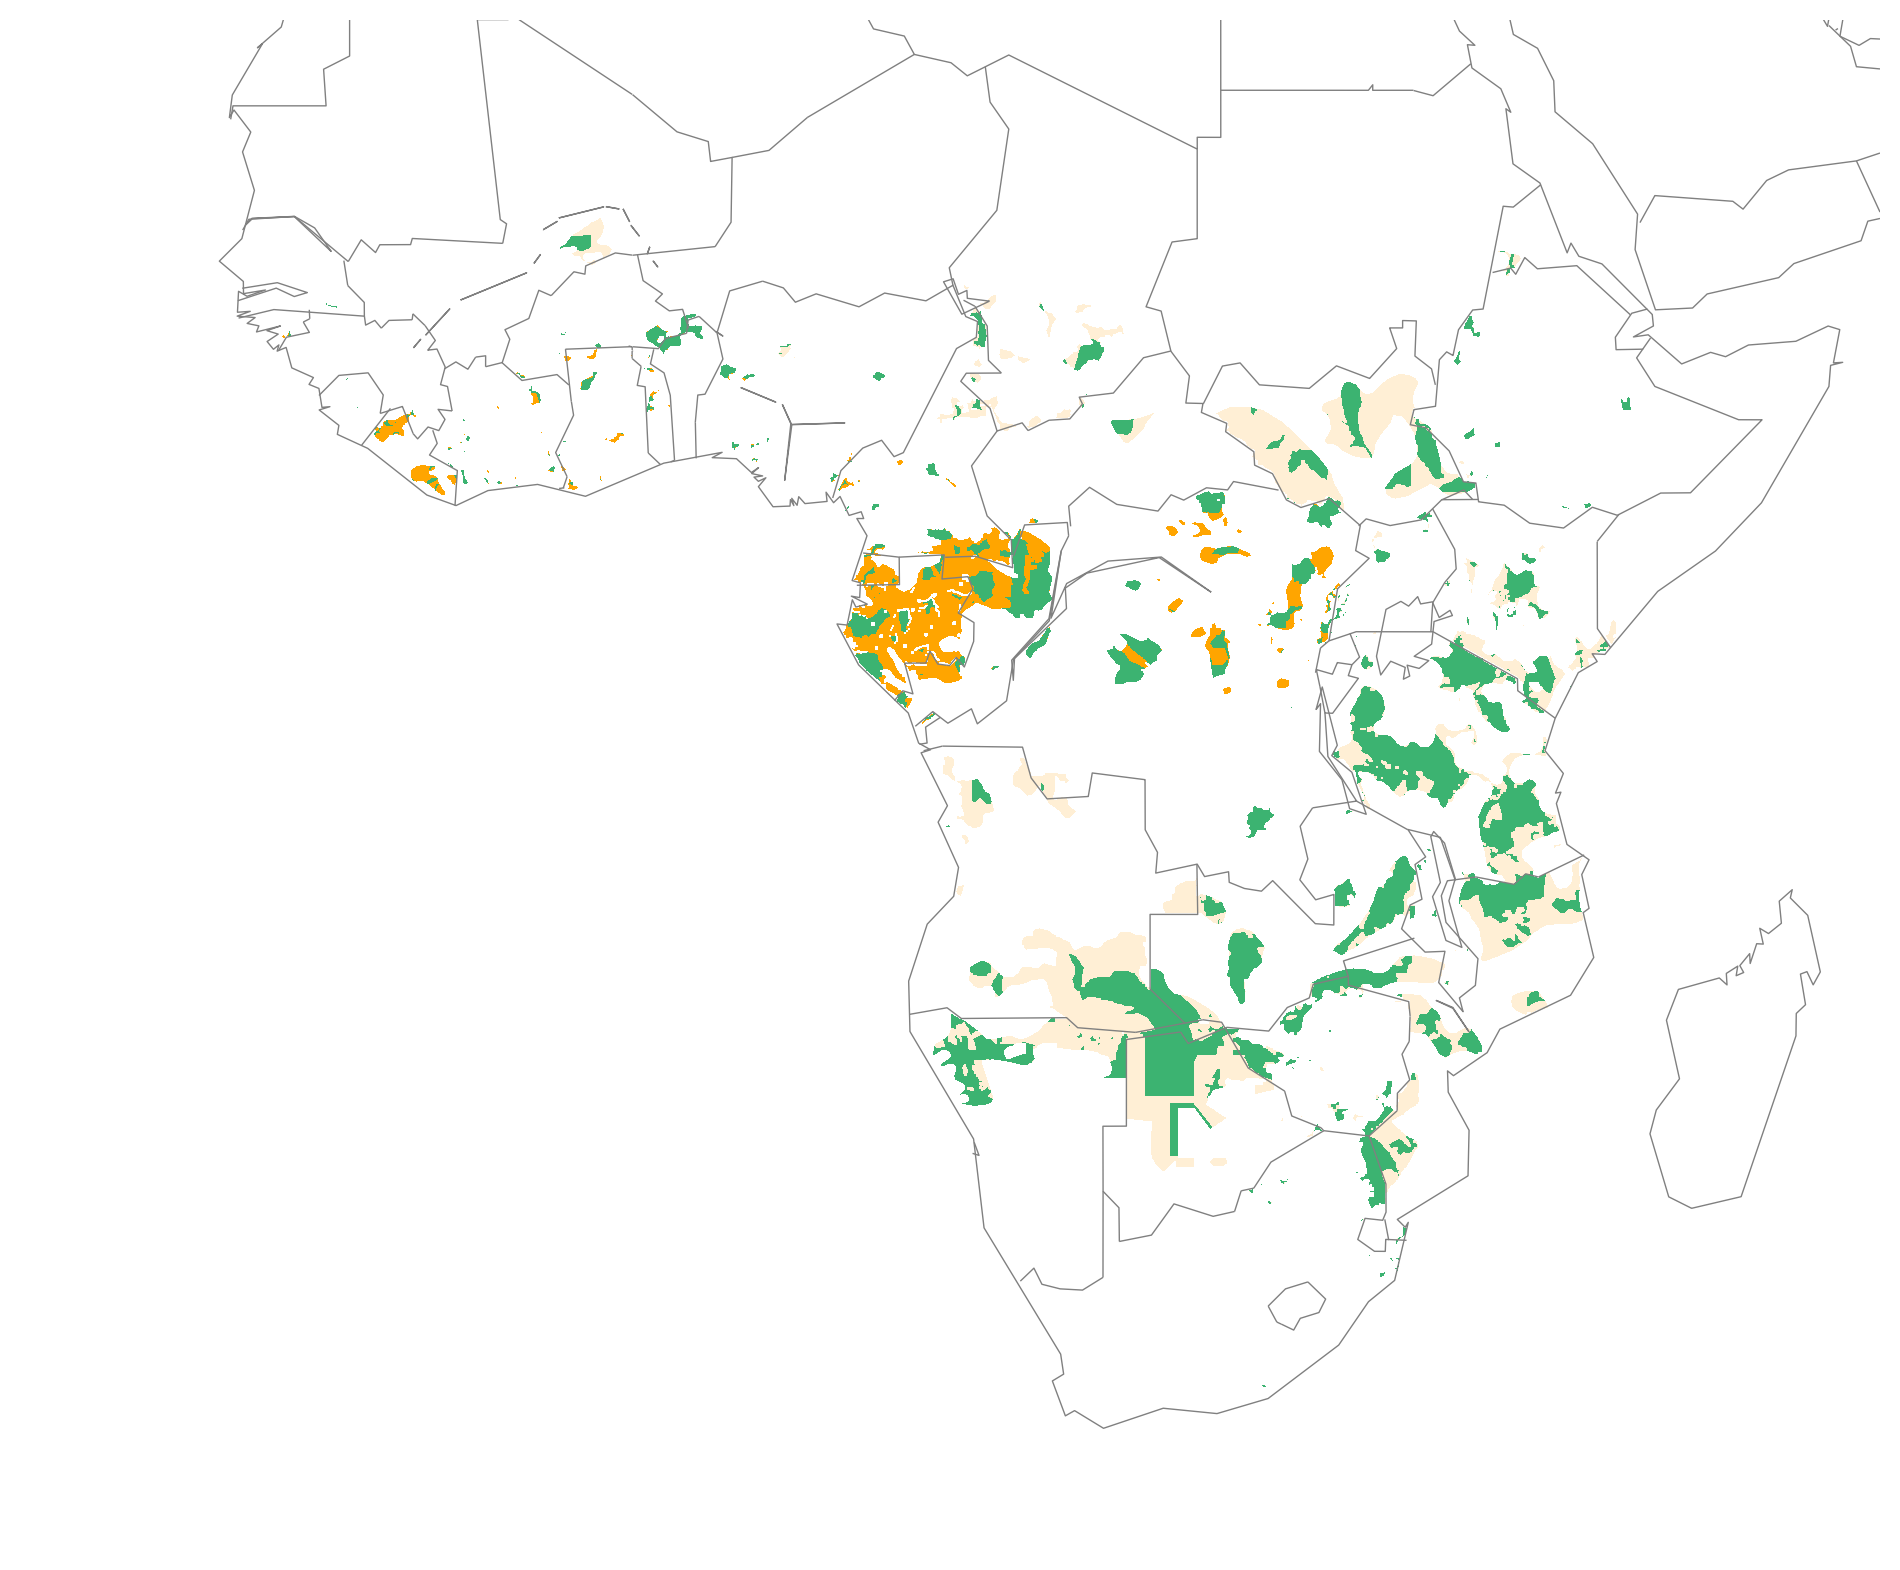

In [19]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
fig=plt.figure(figsize=(6,8))

#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26;lon2 = 53
lat1 = -40;lat2 = 25
fig = plt.figure(figsize=(12,10)) ##width, height default(8,6)
ax = fig.add_subplot(1,1,1)
m = Basemap(width=7900,height=6500,llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
#m.drawmapboundary(linewidth = 0.5)
m.drawcountries(linewidth = 0.5, color = 'gray')
#m.fillcontinents(color = (240/256, 240/256, 240/256))
m.drawlsmask(land_color='none',ocean_color='none',lakes=False)#'gainsboro'#(135/256, 206/256, 234/256)
m.drawcoastlines(linewidth=0.5, color='gray')
#ele=ele.astype(np.float32)
#ele[ele == 0] = np.nan
#ele_protect=ele_protect.astype(np.float32)
#ele_protect[ele_protect == 0] = np.nan
#cmap_custom = matplotlib.cm.ocean_r
#cmap_custom.set_under('white')#指定最小值的颜色
colors1=['none','mediumseagreen']
colors_2=['none','papayawhip']
colors_3=['none','orange']
cmap = mpl.colors.ListedColormap(colors1)
cmap1 = mpl.colors.ListedColormap(colors_2)
cmap2 = mpl.colors.ListedColormap(colors_3)
im1 =m.imshow(LA_da,cmap =cmap1,origin='upper',vmin=0)#
im2 =m.imshow(LC_da,cmap =cmap2,origin='upper',vmin=0)#
im =m.imshow(ele_protect,cmap =cmap,origin='upper',vmin=0)#
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#position=fig.add_axes([0.15, 0.25, 0.25, 0.02])#位置[左,下,右,宽]
#cb = plt.colorbar(im,cax=position,orientation='horizontal')
#cb.ax.tick_params(labelsize=15) 
#cb.set_label('Elephant population density (n/$100km^2$)',fontsize=18,labelpad=10,loc='left')

In [14]:
ele_protect=ele_protect.astype(np.float32)
ele_protect[ele_protect==0]=np.nan
La_pro=LA_da*ele_protect
Lc_pro=LC_da*ele_protect
La_pro_area=np.nansum(LA_da*area)-np.nansum(La_pro*area)
Lc_pro_area=np.nansum(LC_da*area)-np.nansum(Lc_pro*area)

In [15]:
protec=np.nansum(ele_protect*area)#保护区的大象

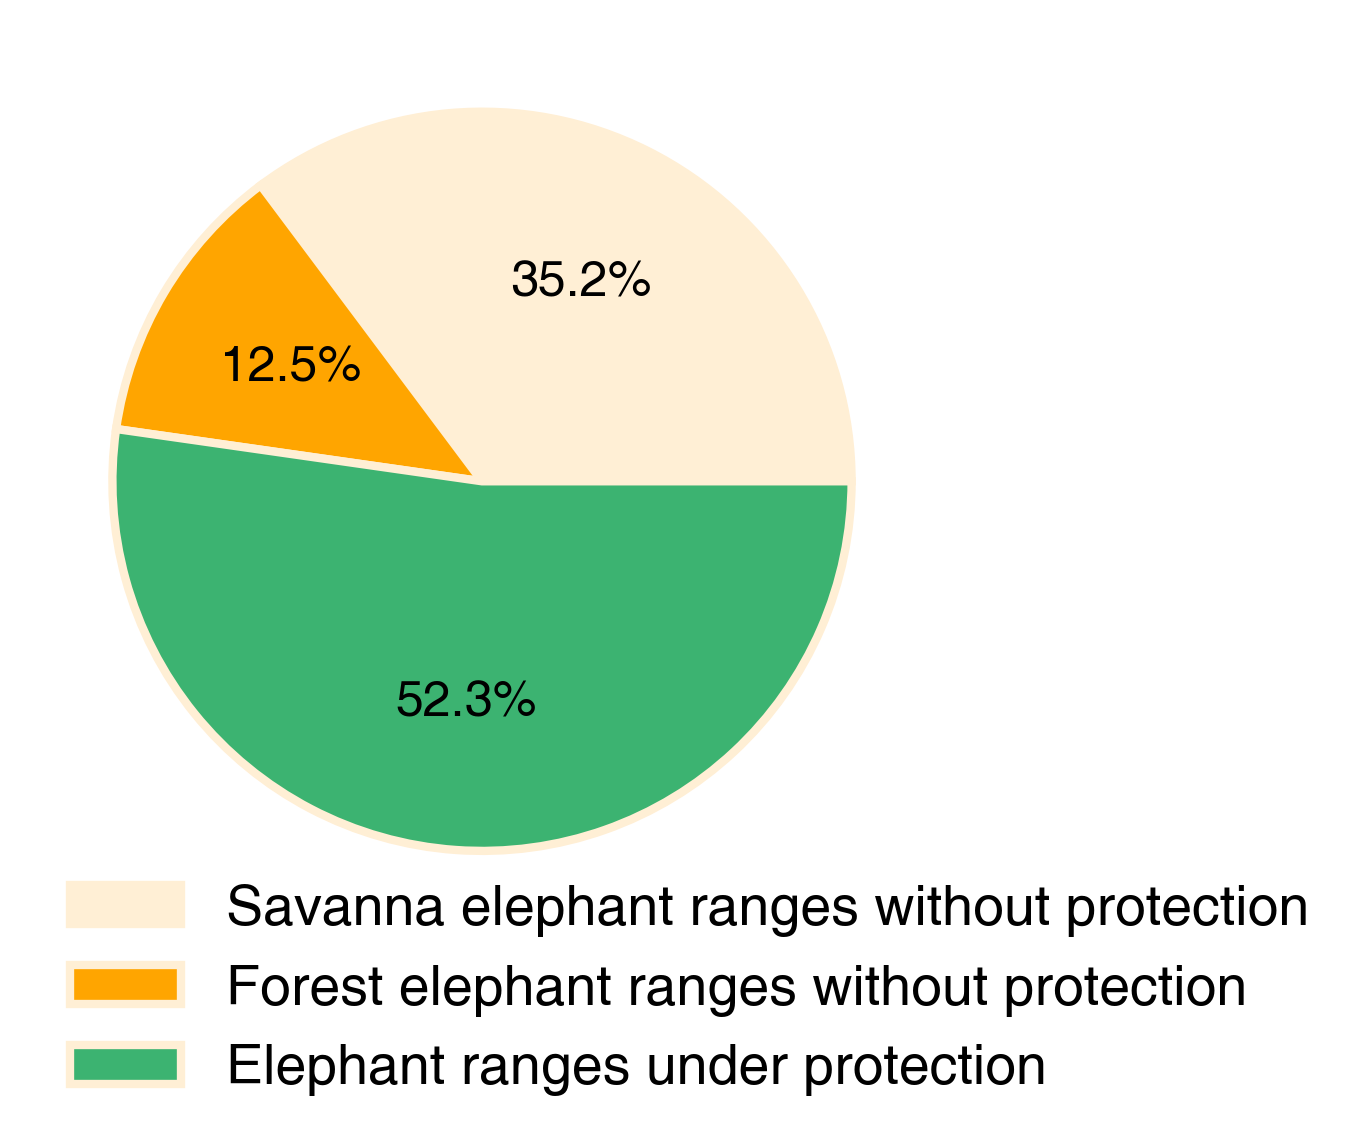

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(6,6)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 20}
plt.rc('font', **font)  # pass in the font dict as kwargs
explode=[0,0,0]#设定各项距离圆心n个半径
cl=['papayawhip','orange','mediumseagreen']
#plt.pie(values[-1,3:6],explode=explode,labels=label,autopct='%1.1f%%')#绘制饼图
#crop=crop_area-scat_area-line_area
label=['Savanna elephant ranges without protection','Forest elephant ranges without protection','Elephant ranges under protection']#定义饼图的标签，标签是列表
values=[La_pro_area,Lc_pro_area,protec]
plt.pie(values,explode=explode,colors=cl,autopct='%1.1f%%',pctdistance=0.6,
                                   wedgeprops={'linewidth': 3, 'edgecolor': "papayawhip"},
                                   textprops= {'fontsize': 18,'fontfamily':'Helvetica'})#绘制饼图
#plt.title('2018年饼图')#绘制标题
#plt.savefig('./2018年饼图')#保存图片
#ax.set(facecolor='none')
#patches[1].set_alpha(0.5)#A组分设置透明度
plt.legend(labels=label,#添加图例
          loc="center left",
          fontsize=20,
          frameon=False,
          bbox_to_anchor=(0.0, -0.55, 0.5, 1))
fig.patch.set_alpha(0.)
plt.show()

In [143]:
La_pro_area,Lc_pro_area

(1112334.9852316931, 395405.12128763547)